In [1]:
import MySQLdb
import torch
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def loadKline(code):
    db = MySQLdb.connect("localhost", "root", "789", "stock", charset='utf8',port=3307 )
    db.query("""select * from company where code='%s'"""%code)
    r = db.store_result()
    company = r.fetch_row()
    db.query("""select volume,open,high,low,close,macd from kd_xueqiu where id=%s"""%company[0][0])
    r = db.store_result()
    k = r.fetch_row(r.num_rows())
    db.close()
    kline = torch.tensor(k).reshape(-1,6)
    return company,kline

# 基本的指标计算公式

In [3]:
"""计算指数移动平均线ema,公式来源于baidu"""
def ema(k,n):
    m = torch.zeros(len(k))
    for i in range(len(k)):
        if i==0:
            m[0] = k[i,4]
        else:
            m[i] = (2*k[i,4]+(n-1)*m[i-1])/(n+1)
    return m    
"""计算macd
DIF=EMA(close，12）-EMA（close，26)
DEA=EMA(DIF,9)
MACD=(DIF-DEA)*2
展开得到
MACD=224/51*EMA(close,9)-16/3*EMA(close,12)+16/17*EMA(close,26)
"""
def macd(k):
    ema9 = ema(k,9)
    ema12 = ema(k,12)
    ema26 = ema(k,26)
    emA = torch.empty(len(k),3)
    emA[:,0] = ema9
    emA[:,1] = ema12
    emA[:,2] = ema26
    return 224.*ema9/51.-16.*ema12/3.+16.*ema26/17.,emA

#k 代表k数组, m 代表macd数组 mm这里也是macd数组, i代表当前位置,n这里无意义
def macdPrediction(k,m,emA,i,n):
    if i-1<0:
        return 0,k[i,4]
    prevMacd = m[i-1]
    #ema9 = (2.*cur+8.*ema[i:i-1,0])/10.
    #ema12 = (2.*cur+10.*ema[i:i-1,1])/13.
    #ema26 = (2.*cur+25.*ema[i:i-1,2])/27.
    #macd = 224.*ema9/51.-16.*ema12/3.+16.*ema26/17. = 0
    #接出来cur等于
    ema9 = emA[i-1,0]
    ema12 = emA[i-1,1]
    ema26 = emA[i-1,2]
    cur = -(224*8.*ema9/510.-16.*11.*ema12/39.+(16.*25.)*ema26/(17.*27.))/(448./510.-32./39.+32./(17.*27.))

    #1 买入预测，0没变，-1 卖出预测
    if cur>k[i,3] and cur<k[i,2]:
        if prevMacd > 0: #卖出时预测值大于最低值
            return -1,cur
        elif prevMacd < 0: #买入时预测值小于最大值
            return 1,cur
    return 0,cur
        
"""计算kdj
n日RSV=（Cn－Ln）/（Hn－Ln）×100
公式中，Cn为第n日收盘价；Ln为n日内的最低价；Hn为n日内的最高价。
"""
def kdj(k,n):
    kdj = torch.zeros(len(k),3) #K,D,J
    for i in range(len(k)):
        if i-n+1>=0:
            prevn = k[i-n+1:i+1,2:4]
        else:
            prevn = k[0:i+1,2:4]
        Ln = prevn.min()
        Hn = prevn.max()
        rsv = (k[i,4]-Ln)*100./ (Hn-Ln)
        if i>=1:
            kdj[i,0] = 2.*kdj[i-1,0]/3.+rsv/3.
            kdj[i,1] = 2.*kdj[i-1,1]/3.+kdj[i,0]/3.
        else:
            kdj[i,0] = 2.*50./3.+rsv/3.
            kdj[i,1] = 2.*50./3.+kdj[i,0]/3.            
        kdj[i,2] = 3.*kdj[i,0]-2.*kdj[i,1]
    return kdj

#对kdJ进行计算预测
def kdjPrediction(k,k_d,kdJ,i,N):
    if i-N<0:
        return 0,k[i,4]
    prev_K_D = k_d[i-1]
    """
    Hn = max(PrevHn,cur)
    Ln = min(PrevLn,cur)
    rsv = (cur-Ln)*100./(Hn-Ln)
    K = 2.*kdJ[i-1,0]+rsv/3.
    D = 2.*kdJ[i-1,1]+K/3.
    K-D = 0
    => rsv = (cur-min(PrevLn,cur))*100./(max(PrevHn,cur)-min(PrevLn,cur)) = 9.*kdJ[i-1,1]-6.kdJ[i-1,0]
    PrevN = k[i-N,i,2:4]
    这里简化下就是新的值没有创出新高和新低
    """
    PrevN = k[i-N:i,2:4]
    PrevHn = PrevN.max()
    PrevLn = PrevN.min()
    cur = (9.*kdJ[i-1,1]-6.*kdJ[i-1,0])*(PrevHn-PrevLn)/100. + PrevLn

    #1 买入预测，0没变，-1 卖出预测
    if cur>k[i,3] and cur<k[i,2]:
        if prev_K_D > 0: #卖出时预测值大于最低值
            return -1,cur
        elif prev_K_D < 0: #买入时预测值小于最大值
            return 1,cur
    return 0,cur    

"""计算均线 n 表示多少日均线"""
def ma(k,n):
    m = torch.zeros(len(k))
    for i in range(len(k)):
        if i-n+1>=0:
            m[i] = k[i-n+1:i+1,4].sum()/n
        else:
            m[i] = k[0:i+1,4].sum()/(i+1)
    return m

"""计算指定范围的均线值"""
def maRange(k,n,bi,ei):
    m = torch.zeros(ei-bi)
    x = torch.arange(bi,ei)
    for i in range(bi,ei):
        if i-n+1>=0:
            m[i-bi] = k[i-n+1:i+1,4].sum()/n
        else:
            m[i-bi] = k[0:i+1,4].sum()/(i+1)
    return x,m    
"""
计算m的切线斜率
"""
def SlopeRates(m):
    r = torch.empty(len(m))
    r[0] = 0
    r[1:len(m)] = m[1:len(m)]-m[0:len(m)-1]
    return r

# 图表绘制

In [4]:
"""绘制k线图"""
def plotK(axs,k,bi,ei):
    for i in range(bi,ei):
        if k[i,1]>k[i,4]:
            c = 'green'
        else:
            c = 'red'
        axs.vlines(i,k[i,3],k[i,2],color=c,zorder=0)
        if k[i,1]>k[i,4]:
            axs.broken_barh([(i-0.4,0.8)],(k[i,1],k[i,4]-k[i,1]+1),facecolor=c,zorder=1)
        else:
            axs.broken_barh([(i-0.4,0.8)],(k[i,1],k[i,4]-k[i,1]+1),facecolor="white",edgecolor=c,zorder=1)
            
def plotVLine(axs,x,c):
    for i in x:
        axs.axvline(i,color=c,linestyle='--')
        
"""标注交易点"""            
def plotTransPt(axs,n,tr,bi,ei):
    inx = np.logical_and(tr[:,0]>=bi,tr[:,0]<=ei)
    axs[0].scatter(tr[inx,0],tr[inx,2],label='buy',marker=">",s=180,color='red')
    plotVLine(axs[0],tr[inx,0],'red')
    for i in range(1,n+1):
        plotVLine(axs[i],tr[inx,0],'red')
    inx = np.logical_and(tr[:,1]>=bi,tr[:,1]<=ei)
    axs[0].scatter(tr[inx,1],tr[inx,3],label='sell',marker="<",s=180,color='blue')
    plotVLine(axs[0],tr[inx,1],'blue')
    for i in range(1,n+1):
        plotVLine(axs[i],tr[inx,1],'blue')

"""打印交易点"""    
def printTrans(k,ma,tr,bi,ei):
    inx = np.logical_and(tr[:,0]>=bi,tr[:,0]<=ei)
    #tr[inx,0] #buy pt
    for ti in tr[inx,0]:
        i = int(ti.item())
        print("buy",i,k[i],ma[i])
    inx = np.logical_and(tr[:,1]>=bi,tr[:,1]<=ei)
    #tr[inx,1] #sell pt
    for ti in tr[inx,1]:
        i = int(ti.item())
        print("sell",i,k[i],ma[i])

def plotVline(axs,v,c,linestyle='--',linewidth=1):
    for i in range(len(axs)):
        axs[i].axvline(v,color=c,linestyle=linestyle,linewidth=linewidth)
        
"""显示K线图，可以组合显示mas,kdj,macd"""
def showKline(k,bi,ei,figsize=(28,12),vlines=None,mas=None,macd=None,kdj=None,trans=None,errors=None,print=False):
    axsInx = 0
    if macd is not None:
        macdInx = axsInx+1
        axsInx += 1
    if kdj is not None:
        kdjInx = axsInx+1
        axsInx += 1
    ht = [[1],[3,1],[2,1,1],[2,1,1,1]]
    widths = [1]
    heights = ht[axsInx]
    gs_kw = dict(width_ratios=widths, height_ratios=heights)
    fig, axs = plt.subplots(axsInx+1, 1,sharex=True,figsize=figsize,gridspec_kw = gs_kw)
    fig.subplots_adjust(hspace=0.02) #调整子图上下间距
    x = np.linspace(bi,ei-1,ei-bi)
    
    if vlines is not None:
        for c in vlines:
            lines = vlines[c]
            for v in lines:
                if v>=bi and v<=ei:
                    plotVline(axs,v,c,linewidth=4 if c=='red' or c=='green' else 1)
                    
    if mas is not None:
        ct = {5:"orange",10:"cornflowerblue",20:"pink",30:"salmon",60:"violet",242:"lime"}
        for m in mas:
            xx,alv = maRange(k,m,bi,ei)
            if m in ct:
                axs[0].plot(xx,alv,label="MA"+str(m),color=ct[m])
            else:
                axs[0].plot(xx,alv,label="MA"+str(m))
    plotK(axs[0],k,bi,ei)
    #axs[0].scatter(x,k[bi:ei+1,4],label="kline",color='orange')
    if trans is not None:
        plotTransPt(axs,axsInx,trans,bi,ei)
        if print:
            printTrans(k,kdj,trans,bi,ei)        
    if errors is not None:
        plotTransPt(axs,axsInx,errors,bi,ei)
        if print:
            printTrans(k,kdj,errors,bi,ei)        
    axs[0].grid(True)

    if macd is not None:
        axs[macdInx].plot(x,macd[bi:ei],label="MACD",color='blue')
        axs[macdInx].axhline(color='black')
        axs[macdInx].grid(True)
    if kdj is not None:
        axs[kdjInx].plot(x,kdj[bi:ei,0],label="K",color='orange')
        axs[kdjInx].plot(x,kdj[bi:ei,1],label="D",color='blue')
        axs[kdjInx].plot(x,kdj[bi:ei,2],label="J",color='purple')
        axs[kdjInx].grid(True)
    plt.show()

"""交换K线图"""
def Kline(k,bi,ei,figsize=(28,12),vlines=None,mas=None,macd=None,kdj=None,trans=None,errors=None,print=False):
    nextbutton = widgets.Button(description="下一页")
    prevbutton = widgets.Button(description="上一页")
    output = widgets.Output()
    
    #display([prevbutton,nextbutton], output)
    #display(nextbutton, output)

    items_layout = Layout( width='auto')     # override the default width of the button to 'auto' to let the button grow

    box_layout = Layout(display='flex',
                        flex_flow='row',
                        align_items='stretch',
                        border='solid',
                        width='50%')

    words = ['correct', 'horse', 'battery', 'staple']
    items = [prevbutton,nextbutton]
    box = Box(children=items, layout=box_layout)
    
    beginPT = bi
    endPT = ei
    showRange = ei-bi
    
    def on_nextbutton_clicked(b):
        nonlocal beginPT,endPT,showRange
        beginPT += showRange
        endPT += showRange
        if endPT >= len(kline):
            endPT = len(kline)
            beginPT = endPT-showRange        
        output.clear_output(wait=True)
        with output:
            showKline(k,beginPT,endPT,figsize=figsize,vlines=vlines,mas=mas,macd=macd,kdj=kdj,trans=trans,errors=errors)
    
    def on_prevbutton_clicked(b):
        nonlocal beginPT,endPT,showRange
        beginPT -= showRange
        endPT -= showRange
        if beginPT < 0 :
            endPT = showRange
            beginPT = 0
        output.clear_output(wait=True)        
        with output:
            showKline(k,beginPT,endPT,figsize=figsize,vlines=vlines,mas=mas,macd=macd,kdj=kdj,trans=trans,errors=errors)
            
    nextbutton.on_click(on_nextbutton_clicked)
    prevbutton.on_click(on_prevbutton_clicked)
    
    display(box,output)
    with output:
        showKline(k,beginPT,endPT,figsize=figsize,vlines=vlines,mas=mas,macd=macd,kdj=kdj,trans=trans,errors=errors)
    

In [5]:
c,kline = loadKline('SZ399001')
#c,kline = loadKline('SH601939')

kdJ = kdj(kline,9)
macD,emA = macd(kline)

# 计算不同指标的收益
1. macd 基线
2. kdj 基线

In [6]:
"""计算不同指标的收益
len(k) === len(m)
"""
def calcBaseline(k,m,bi,ei):
    r = 1.
    prev = m[bi]
    buy = -1
    tr = []
    for i in range(bi+1,ei):
        macD = m[i]
        if macD*prev<0:
            close = k[i,4]
            if macD>0:
                buy = close
                buyi = i
            elif buy>0:
                tr.append([buyi,i,buy,close])
                r *= close/buy
                buy = -1
        prev = macD
    return r,np.array(tr)

"""计算不同指标的收益 加入特殊判断的版本
len(k) === len(m) 
"""
def calcBaseline_KDJ(k,m,bi,ei,kdJ,buyLessPt):
    r = 1.
    prev = m[bi]
    buy = -1
    tr = []
    for i in range(bi+1,ei):
        macD = m[i]
        if macD*prev<0:
            close = k[i,4]
            if macD>0 and kdJ[i,0]<buyLessPt:
                buy = close
                buyi = i
            elif buy>0:
                tr.append([buyi,i,buy,close])
                r *= close/buy
                buy = -1
        prev = macD
    return r,np.array(tr)

"""计算不同指标的收益
len(k) === len(m)
考虑买入卖出点是更加精确的进出点,使用平均收盘法
"""
def calcAvgBaseline(k,m,bi,ei):
    r = 1.
    prev = m[bi]
    buy = -1
    tr = []
    for i in range(bi+1,ei):
        macD = m[i]
        if macD*prev<0:
            if macD>0:
                buy = (k[i-1,4]+k[i,4])/2.
                buyi = i
            elif buy>0:
                sell = (k[i-1,4]+k[i,4])/2.
                tr.append([buyi,i,buy,sell])
                r *= sell/buy
                buy = -1
            prev = macD
    return r,np.array(tr)

"""计算不同指标的收益
len(k) === len(m)
考虑买入卖出点是更加精确的进出点,使用实际计算法,并且加入错误纠正
m是判断值,-变+买入，+变-卖出，mm是实际值
例如：m是kdj_k-kdj_d ,mm是kdj
"""
def calcFormulaBaseline(k,m,mm,bi,ei,f,N=9):
    r = 1.
    prev = m[bi]
    buy = -1
    tr = [] #正常交易
    er = [] #错误交易
    
    err = 1. #错误交易的收益
    for i in range(bi+1,ei):
        macD = m[i]
        """
        1.实际发生改变，预测也发生改变，按预测加买入
        2.实际没发生改变，预测发生改变，预测价买入，第二天开盘卖出
        b = 1 买入预测，0没变，-1 卖出预测
        """
        if buy==-1 and prev<0: #正在寻找买入点
            b,v = f(k,m,mm,i,N)
            if (b==1 or b==0) and macD>0: #预测正确 或者 没有预测出来
                buy = v if b==1 else k[i,4]
                buyi = i
            elif b==1 and macD<0: #预测错误,纠正来天开盘出货
                buy = v if b==1 else k[i,4]
                sell = k[i+1,1] if i+1<ei else buy
                r *= sell/buy
                err *= sell/buy
                er.append([i,i+1,buy,sell])
                buy = -1
        elif buy>0 and prev>0: #正在找卖出点
            b,v = f(k,m,mm,i,N)
            if (b==-1 or b==0) and macD<0: #预测正确 或者 没有预测出来
                sell = v if b==1 else k[i,4]
                tr.append([buyi,i,buy,sell])
                r *= sell/buy
                buy = -1
            elif b==-1 and macD>0: #预测错误，纠正收盘前买回来
                sell = v
                er.append([buyi,i,buy,sell])
                r *= sell/buy
                err *= sell/buy
                buy = k[i,4]
        prev = macD
    return r,np.array(tr),err,np.array(er)

# MACD基线
简单的在金叉买入死叉卖出，买入和卖出都是改变日的收盘价

tensor(8.6397) 175


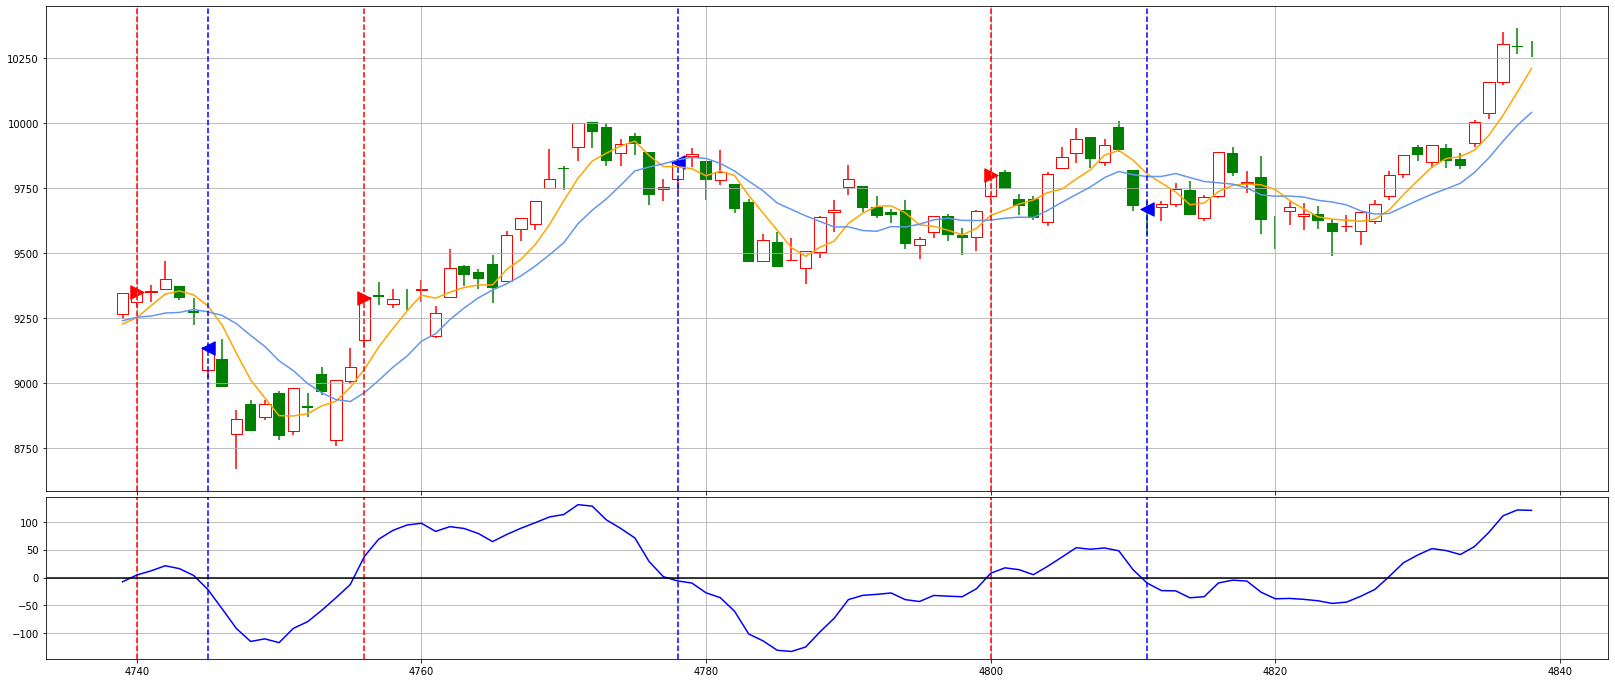

In [7]:
r,tr = calcBaseline(kline,macD,0,len(kline))
print(r,len(tr))
showKline(kline,len(kline)-100,len(kline),mas=[5,10],macd=macD,trans=tr)

# KDJ基线
简单的在金叉买入死叉卖出，买入和卖出都是改变日的收盘价

tensor(2.4891) 431


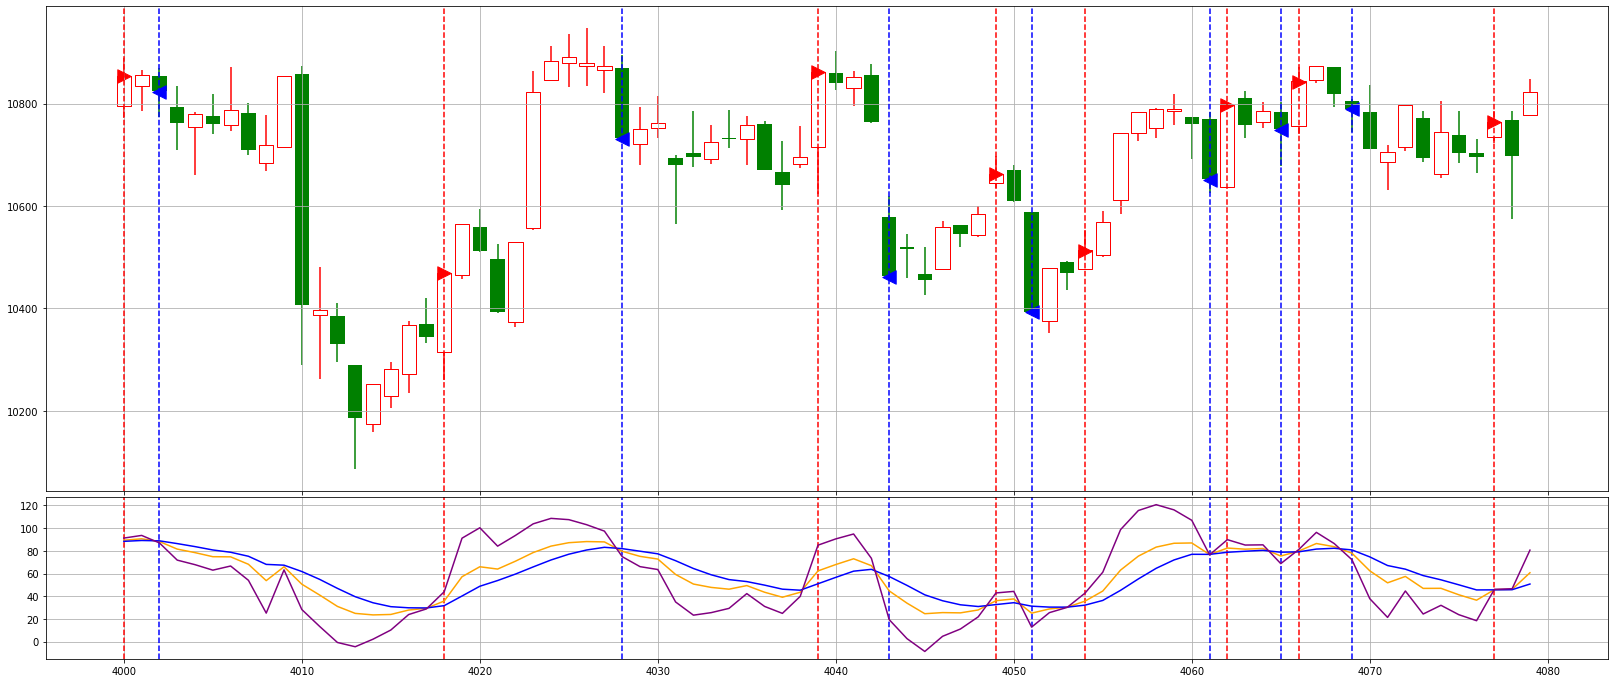

In [8]:
r,tr = calcBaseline(kline,kdJ[:,0]-kdJ[:,1],0,len(kline))
print(r,len(tr))
showKline(kline,4000,4080,kdj=kdJ,trans=tr)

# MACD平均值基线
在金叉和死叉使用变化两边的收盘均价进行买入和卖出

tensor(115.2634) 175


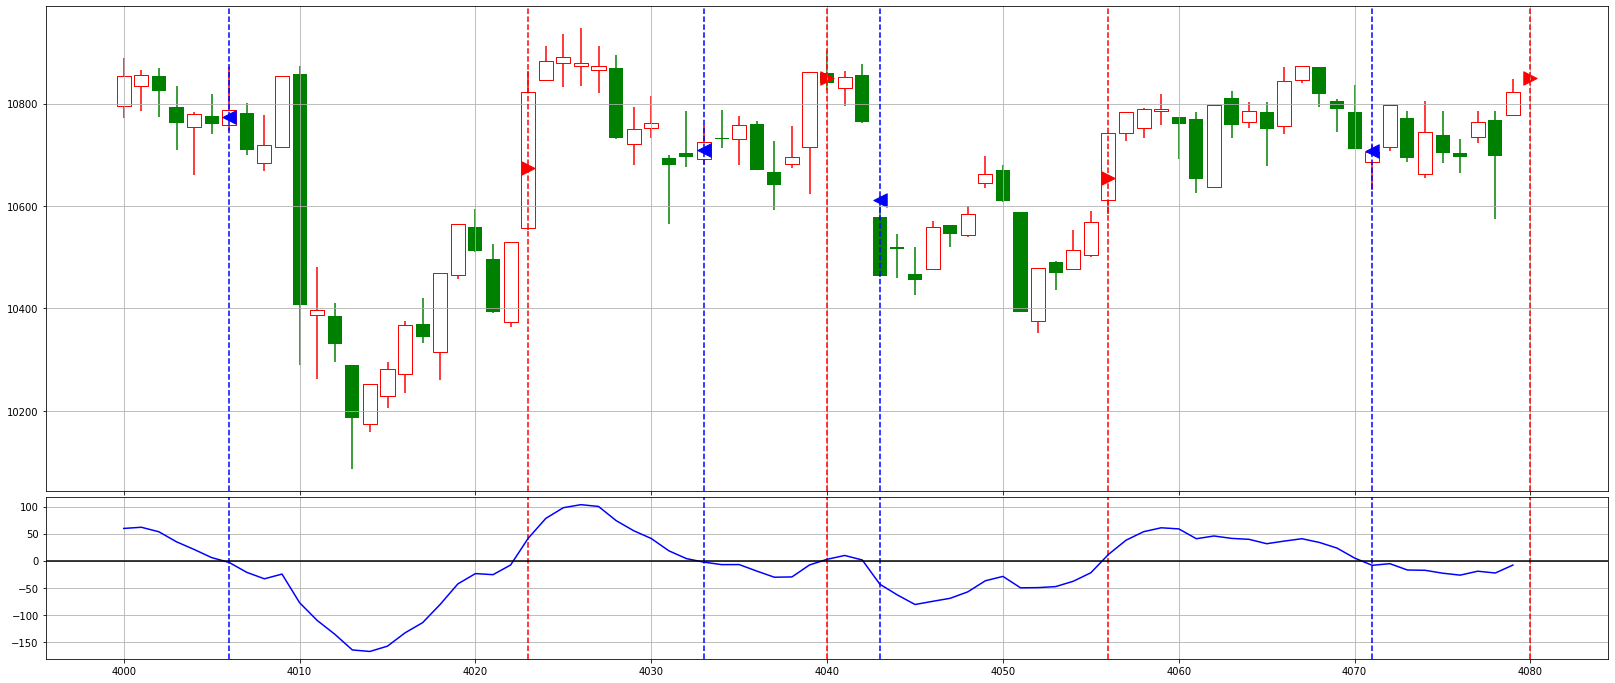

In [9]:
r,tr = calcAvgBaseline(kline,macD,0,len(kline))
print(r,len(tr))
showKline(kline,4000,4080,macd=macD,trans=tr)

# KDJ平均值基线
在金叉和死叉使用变化两边的收盘均价进行买入和卖出

tensor(2733.7922) 431


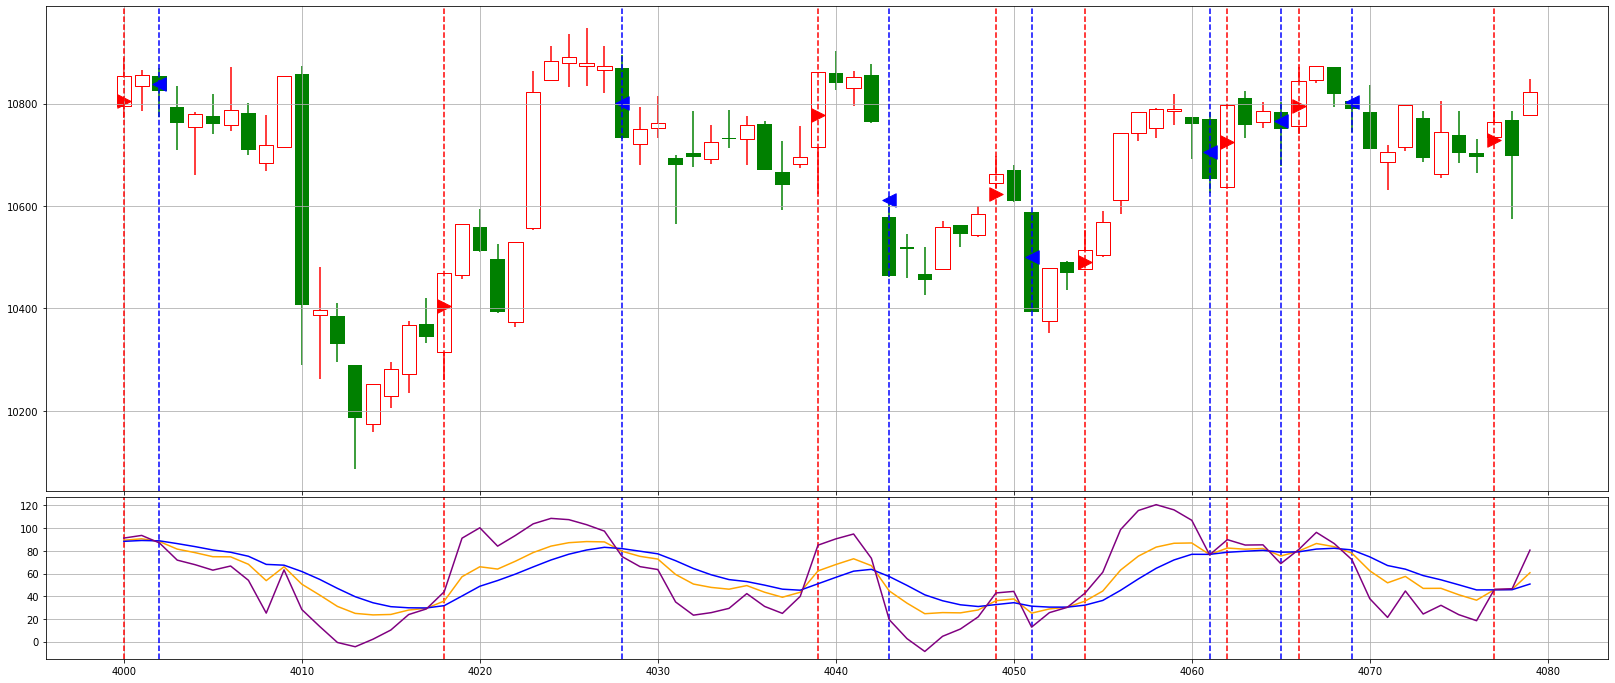

In [10]:
r,tr = calcAvgBaseline(kline,kdJ[:,0]-kdJ[:,1],0,len(kline))
print(r,len(tr))
showKline(kline,4000,4080,kdj=kdJ,trans=tr)

# MACD的预测操作基线
使用macd,或者kdj的公式预测达到金叉需要的价格，然后在到达后购买，如果收盘时发现失败进行操作纠正。比如买盘错误就在来天开盘卖出，如果买盘错误就在收盘前买回。

tensor(2.9513) 175 tensor(3.0332) 206


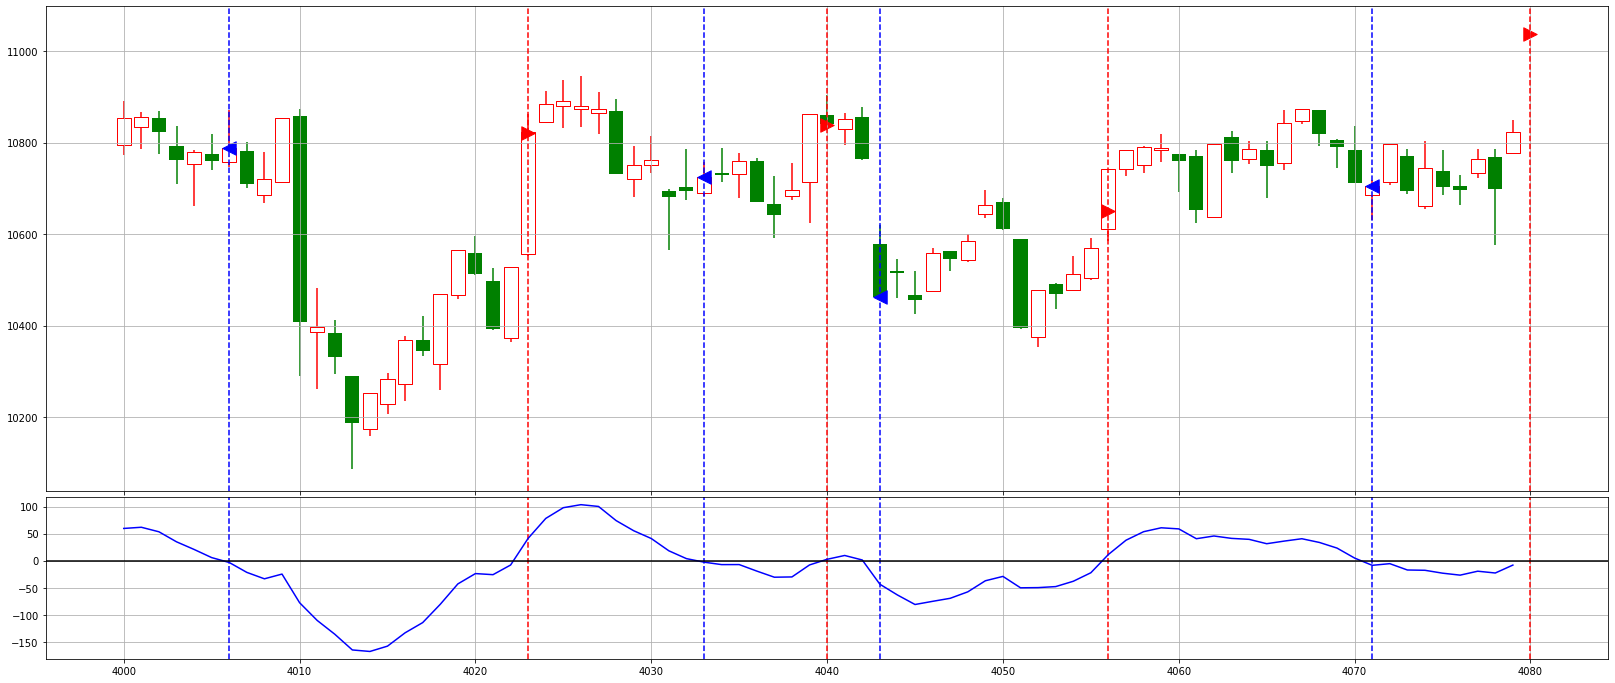

In [11]:
r,tr,err,er = calcFormulaBaseline(kline,macD,emA,0,len(kline),macdPrediction)
print(r,len(tr),err,len(er))
showKline(kline,4000,4080,macd=macD,trans=tr)

# KDJ的预测操作基线
使用macd,或者kdj的公式预测达到金叉需要的价格，然后在到达后购买，如果收盘时发现失败进行操作纠正。比如买盘错误就在来天开盘卖出，如果买盘错误就在收盘前买回。

tensor(1.2667) 431 tensor(5.5304) 280


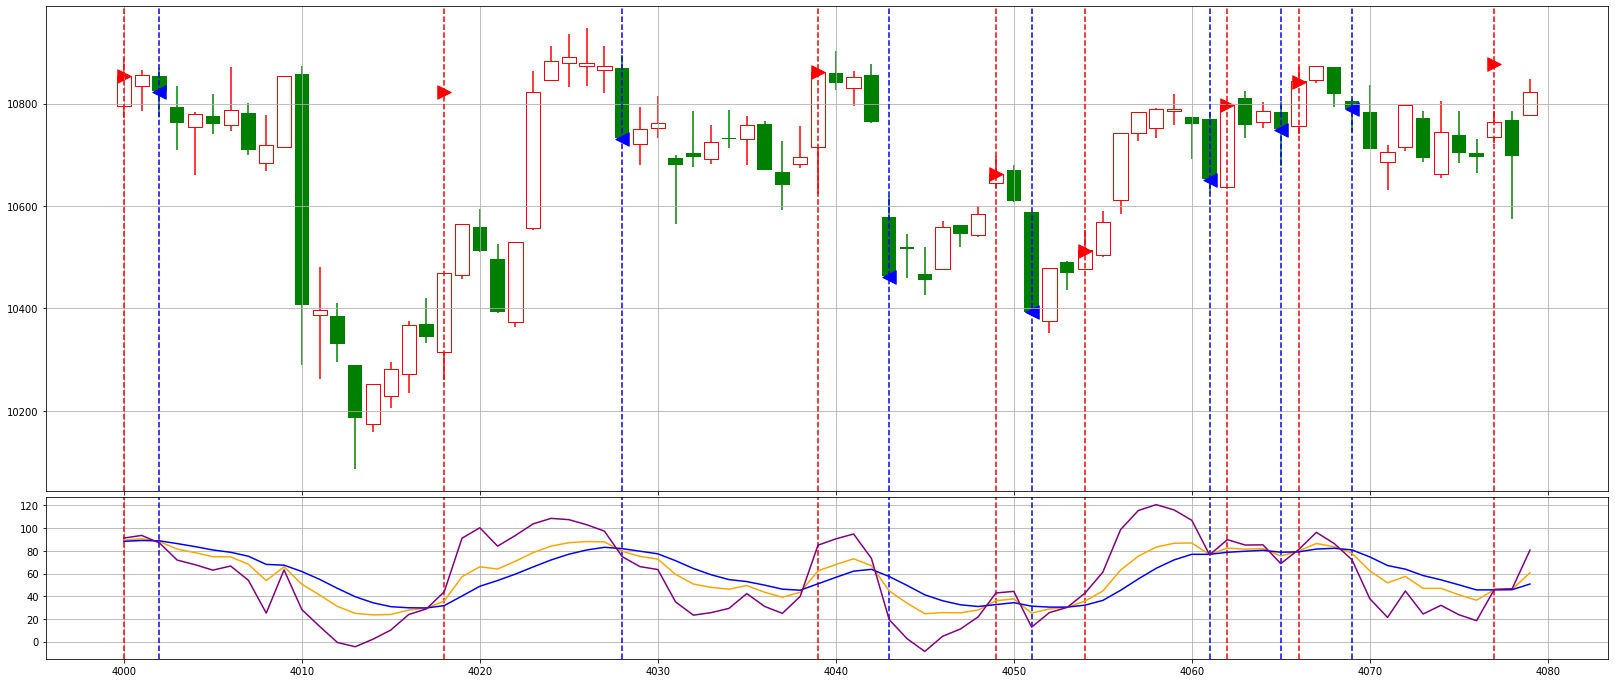

In [12]:
r,tr,err,er = calcFormulaBaseline(kline,kdJ[:,0]-kdJ[:,1],kdJ,0,len(kline),kdjPrediction,9)
print(r,len(tr),err,len(er))
showKline(kline,4000,4080,kdj=kdJ,trans=tr)